<a href="https://colab.research.google.com/github/dkdk22/123/blob/master/DL_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Firstly let's import all the necessary packages and update them.

Also check the type of runtime environment.

In [ ]:
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from dl_utils import plot_history

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.15.0
3.0.5


In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)

(60000, 28, 28)


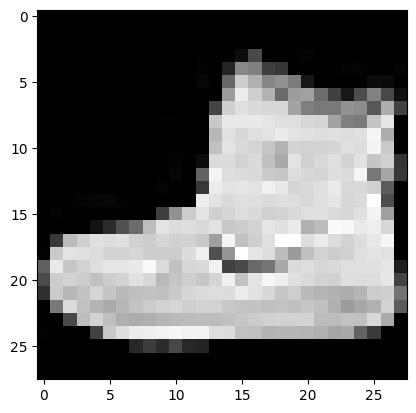

Label = 9


In [ ]:
# Show an instance
plt.imshow(X_train[0], cmap="gray")


plt.show()
print("Label =", y_train[0])


In [ ]:
# Input data preprocessing
print(np.min(X_train), np.max(X_train))
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

0 255
60000 train samples
10000 test samples


In [ ]:
# Labels preprocessing
print(np.min(y_train), np.max(y_train))
num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("First label is now = ", y_train[0])

0 9
First label is now =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Build the model
We use a simple fully connected network here using 8 hidden neurons, followed by another layer of 8 hidden neurons, and finally our output layer. We use the ReLU activation function, except for the output, where we apply a softmax activation as we're doing a multiclass classification here.


In [ ]:
def MLPModel(num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
model = MLPModel(num_classes)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)
    print(layer.get_config())
    print()

0 flatten_5
{'name': 'flatten_5', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}

1 dense_15
{'name': 'dense_15', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}

2 dense_16
{'name': 'dense_16', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias

In [ ]:
class MyMLPModel(kt.HyperModel):
  # Sets up the hyperparameters and calls the building model function
  def build(self, hp):
        model = self.build_MLP(hp)
        return model

  # Sets up the hyperparameters and calls the building model function
  def build_MLP(self, hp):
      # Tune the number of units for the Dense layers
      hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
      hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)

      # Choose the activation function for the Dense layers
      hp_activation = hp.Choice("activation", ["relu", "tanh"])

      # Tune the learning rate for the optimizer
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      # call existing model-building code with the hyperparameter values.
      model = self.build_MLP_hp(
          hp_units1=hp_units1, hp_units2=hp_units2, hp_activation=hp_activation,
          hp_learning_rate=hp_learning_rate
      )
      return model

  # Builds the actual model
  def build_MLP_hp(self, hp_units1, hp_units2, hp_activation, hp_learning_rate):
      model = Sequential()
      model.add(Flatten(input_shape=(28, 28)))
      model.add(Dense(units=hp_units1, activation=hp_activation))
      model.add(Dense(units=hp_units2, activation=hp_activation))
      model.add(Dense(10, activation="softmax"))
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy", metrics=["accuracy"])
      return model

  def fit(self, hp, model, *args, **kwargs):
           # Initialize ImageDataGenerator for data augmentation
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2
        )
        print("previous args :",args[0].shape)
        X_train=args[0]
        X_train= X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        datagen.fit(X_train)
        # Fit the data generator on the training data
        # Use the generator to augment the data during training
        return model.fit(
        datagen.flow(X_train, y_train, batch_size=hp.Choice("batch_size", [16, 32, 64, 128, 256]), shuffle=True, subset='training'),
        validation_data=datagen.flow(X_train, y_train,subset='validation'),  # Use original data for validation
        steps_per_epoch=10,  # Adjust as needed
        epochs=5
    )

In [ ]:
tuner = kt.Hyperband(MyMLPModel(),
                     objective='val_accuracy',
                     max_epochs=10)
tuner.search_space_summary()

Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
batch_size (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}


# Training


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3430 - loss: 1.6819 - val_accuracy: 0.7673 - val_loss: 0.6949
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7766 - loss: 0.6466 - val_accuracy: 0.8037 - val_loss: 0.5682
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8050 - loss: 0.5655 - val_accuracy: 0.8150 - val_loss: 0.5291
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8242 - loss: 0.5158 - val_accuracy: 0.8238 - val_loss: 0.5107
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8292 - loss: 0.5016 - val_accuracy: 0.8183 - val_loss: 0.5054


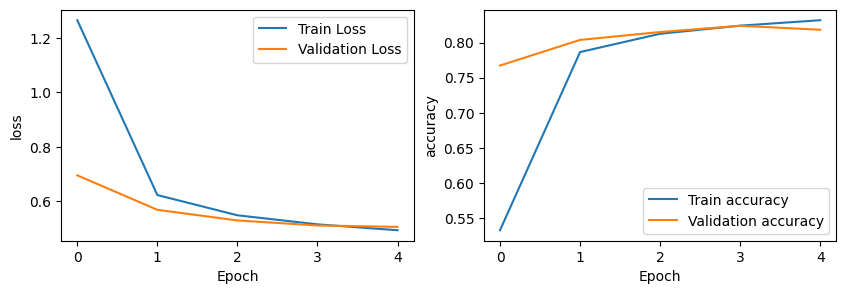

In [ ]:
# Basic training

batch_size = 128
epochs = 5

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
plot_history(history)

In [ ]:
# KerasTuner training

# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=5, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 20 epochs
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Trial 22 Complete [00h 01m 26s]
val_accuracy: 0.6140000224113464

Best val_accuracy So Far: 0.6319166421890259
Total elapsed time: 00h 21m 04s

Search: Running Trial #23

Value             |Best Value So Far |Hyperparameter
448               |352               |units
tanh              |relu              |activation
0.001             |0.001             |learning_rate
32                |128               |batch_size
10                |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |0                 |tuner/round

previous args : (60000, 28, 28)
Epoch 1/5
10/10 [==============================] - 10s 1s/step - loss: 2.2784 - accuracy: 0.2594 - val_loss: 1.7535 - val_accuracy: 0.3373
Epoch 2/5
10/10 [==============================] - 10s 1s/step - loss: 1.6122 - accuracy: 0.3688 - val_loss: 1.4813 - val_accuracy: 0.4597
Epoch 3/5
10/10 [==============================] - 11s 1s/st

In [ ]:
print(model.layers[1].get_weights()[0].shape)  # weights
print(model.layers[1].get_weights()[1].shape)  # bias

(784, 8)
(8,)


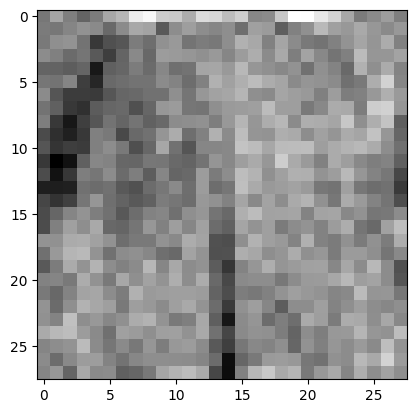

In [ ]:
# Visualizing weights of first dense layer
rs = model.layers[1].get_weights()[0][:, 0].reshape(28, 28)
plt.imshow(rs, cmap="gray")
plt.show()

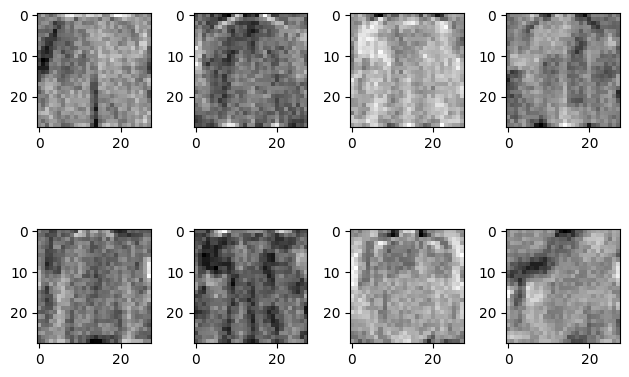

In [ ]:
# Show all 8 weights of the first dense layer
gs = gridspec.GridSpec(2, 4)
for n in range(8):
    rs = model.layers[1].get_weights()[0][:, n].reshape(28, 28)
    ax = plt.subplot(gs[n])
    ax.imshow(rs, cmap="gray")
plt.tight_layout()
plt.show()

# Evaluation

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

print("Basic model")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Basic model
Test loss: 0.5250500440597534
Test accuracy: 0.8166999816894531


In [ ]:
score = best_model.evaluate(X_test, y_test, verbose=0)

print("Keras Tuner model")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Keras Tuner model
Test loss: 0.3371146321296692
Test accuracy: 0.8888999819755554


In [ ]:
scores = model.predict(np.array([X_train[0]]))

print(scores)
print("Predicted label = ", np.argmax(scores))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
[[1.8901978e-09 9.2499075e-10 7.4716864e-09 3.4436587e-10 4.3080907e-11
  4.7780806e-04 1.4351339e-06 1.4426763e-05 1.7205109e-04 9.9933428e-01]]
Predicted label =  9
